# Data analysis: effect of different parameters in PA; how to choose the right ones

This notebook presents the main findings of our work done in scope of the Network Science Seminar at ETHZ. To run the code, the simulation library we wrote is required. The library is based on the code found at: https://github.com/StefaniaI/ABM-IFforSMI; we mostly re-wrote it to be more efficient for our purposes, at the cost of not being able to perform all the experiments the authors of the initial paper performed. Our code can be found on the following public github page: https://github.com/GernotZock/networkproject

We first import the needed libraries. You might need to install them if you did not already.

In [136]:
import simulation as sim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings. filterwarnings('ignore') 

## Set Up Plotting Functions

This is just boring code. Ignore if you want to see results only.

In [229]:
def plot_density_times(results):
    'Returns a plot of the density of the number of timesteps it took for the simulations to converge.'
    timesteps = []
    for result in results.values():
        timesteps.append(result['timesteps'])
    sns.kdeplot(np.array(timesteps))
    plt.xlabel('Time until convergence')

def average_time(results):
    timesteps = []
    for result in results.values():
        timesteps.append(result['timesteps'])
    return np.mean(timesteps)    

def plot_hist_times(results, nbins = 10):
    'Returns a plot of the density of the number of timesteps it took for the simulations to converge.'
    timesteps = []
    for result in results.values():
        timesteps.append(result['timesteps'])
    plt.hist(np.array(timesteps), bins = nbins)
    plt.xlabel('Time until convergence')

In [102]:
# defining the different fairness metrics

def binary_fair(id_to_position_popularity: dict, i: int, offset: int = 0):
        '''
        Helper function to compute the popularity score of user i. If there are at most offset many
        CCs of lower quality with more followers than CC_i, we say it is fair. Otherwise unfair. 
        args:
                id_to_position_popularity: dictionary mapping user id to their popularity rank
        '''
        return id_to_position_popularity[i] - (i + offset) <= 0 

def calculate_fairness(popularity: list, fairness_fct) -> list:
    '''Given a list of follower counts for content creators in the order of their 
    quality finds if each is treated fairly.
    
    Input
    ------
    popularity: list
       List of nonegative integers corresponding to follower counts for each creator
    fairness_fct: a function that evaluates fairness of a content creator given the popularity list data
    ------
    
    Output
    ------
    fairness_scores: list
        A list such that fairness_scores[i] denotes the fairness score of content creator i.
    ------   
    '''
    
    num_CCs = len(popularity)

    # get the inexes of CCs by the number of followers
    popularity = np.array(popularity)
    ordered_by_popularity = np.flip(popularity.argsort())
    id_to_position_popularity = {i:pos for pos, i in enumerate(ordered_by_popularity)}

    return np.array([fairness_fct(id_to_position_popularity, i) for i in range(num_CCs)])

def plot_fairness(results, fairness_fct):
    '''
    plots fairness scores. x-axis will be the CC id, y-axis in what percentage of outcomes
    of the simulations the CC was treated fairly.
    '''
    fairness_scores = []
    for result in results.values():
        fairness_scores.append(calculate_fairness(result['num_followers'], fairness_fct))
    fairness_scores = np.array(fairness_scores, dtype = float)
    plt.plot(np.array(fairness_scores).mean(axis = 0))

def user_satisfaction(results):
    satisfaction_scores = []
    for result in results.values():
        satisfaction_scores.append(np.mean(result['user_satisfaction']))
    return np.mean(satisfaction_scores)

def plot_average_fairness(results, fairness_fct):
    fairness_scores = []
    for result in results.values():
        fairness_scores.append(calculate_fairness(result['num_followers'], fairness_fct))
    fairness_scores = np.array(fairness_scores, dtype = int)
    sns.kdeplot(np.mean(fairness_scores, axis = 1))
    plt.xlabel('Average fairness score')
    plt.ylabel('Density of that average score over all simulations')

def average_fairness(results, fairness_fct):
    fairness_scores = []
    for result in results.values():
        fairness_scores.append(calculate_fairness(result['num_followers'], fairness_fct))
    fairness_scores = np.array(fairness_scores, dtype = int)
    return np.mean(fairness_scores)

In [103]:
def plot_probabilities2(results: dict, CC: int):
    data = []
    for i in results.keys():
        evolutionary_data = results[i]['evolutionary_data']
        data_ = [x['probs'][CC] for x in evolutionary_data.values()]
        data.append(data_)
    max_len = max([len(x) for x in data])
    average_probs = np.zeros(max_len)
    num_occurences = np.zeros(max_len)
    for sim in data:
        i = 0
        while i < len(sim):
            average_probs[i] = average_probs[i] * (num_occurences[i])/(num_occurences[i]+1) + sim[i] / (num_occurences[i]+1)
            num_occurences[i] += 1
            i += 1

    plt.plot(average_probs)
    plt.xlabel('Timesteps')
    plt.ylabel('Probability that CC_i gets recommended')
    plt.xticks(range(0, 20), [10, 20] + ['']*18)
    plt.title('Evolution of the probability that CC_i gets recommended over time')

## Set-Up of the experiments

In our experiments, we closely follow the set-up of the original paper. That is, we run the recommendation procedure 100 times. Each run, as actions depend on randomness, will be different. In the initial paper, these results are then averaged and interpreted. We are doing the same. 

We made significant changes in the code-base that was provided by the authors though - this was done to improve efficiency of the algorithms and thus do the experiments on our own Laptops, which do not have much compute power.

We simulate, unless otherwise specified, with 100 CCs (where CC_0 is the best quality and CC_99 the worst), and 10000 users.

## Fine Grained results on convergence times for different regimes

In this section, we first analyze how long the recommendation procedure takes to converge. It converges once every user follows the best content creator (CC_0). This is an important parameter, as only when the network has converged, every user will get the best content. In intermediary states, users do not see it yet.

We will use a density plot, where the x-axis denotes the number of time-steps required until convergence, and the y-axis the density of experiments that take x timesteps until convergence. In these plots, you can also quite well see that the distribution is quite well concentrated, showing that in fact taking average statistics is not a terrible idea, at least to get information on the level of orders of magnitude.

We remind the reader that the alpha value determines the recommendation process as follows:

If $\mathbb{P}\left(R_\alpha^t(s)=i\right)$ denotes the probability of $CC_i$ being recommended to user $s$ at timestep $t$, then
$$\mathbb{P}\left(R_\alpha^t(s)=i\right)=\frac{\left(1+a_{., i}^t\right)^\alpha}{\sum_{j \in \bar{n}}\left(1+a_{., j}^t\right)^\alpha}$$

where $a_{., j}^t$ denotes the number of followers that $CC_j$ has at time $t$.

In [104]:
results_dict = dict()

As a note: We focus on values of $\alpha$ with small absolute value; both in the results of the paper as well as in our own experiments larger values were inferior to smaller values in terms of convergence and fairness, so we decided to omit them.

### $\alpha = 1$

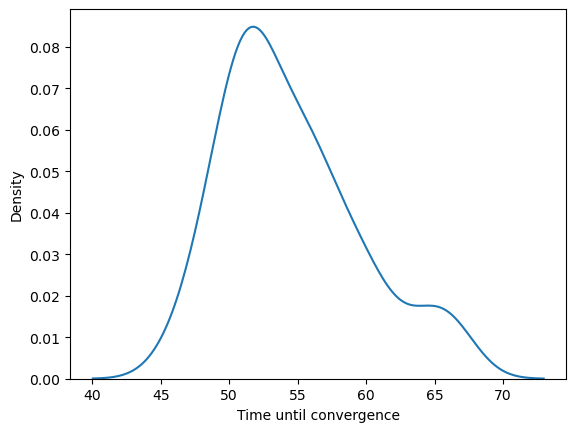

In [153]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [1], num_steps = None, random_seed = 42, evolution = 50)
results = simulation.simulate()
results_dict[1] = results
plot_density_times(results)

### $\alpha = 2$

This parameter leads to significantly faster convergence times than $\alpha = 1$

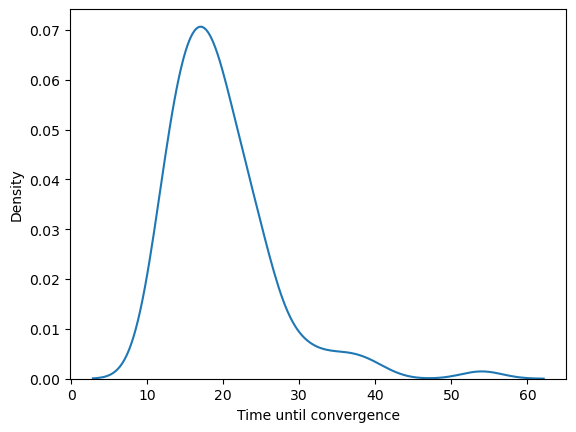

In [154]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [2], num_steps = None, random_seed = 42, evolution = 50)
results = simulation.simulate()
results_dict[2] = results
plot_density_times(results)

### $\alpha = 3$

One we hit the regime where $\alpha$ becomes too large, the density plot does not even give good plots anymore because of high variance. We thus plot a histogram. We can see that in this scenario, the variance is very high; even though most simulations converge after $< 1000$ iterations, there are a few which take up to $5000$! We thus argue that large values for $\alpha$ are not advised to choose because of the high variance and uncertainty.

In [107]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [3], num_steps = None, random_seed = 42)
results = simulation.simulate()
results_dict[3] = results

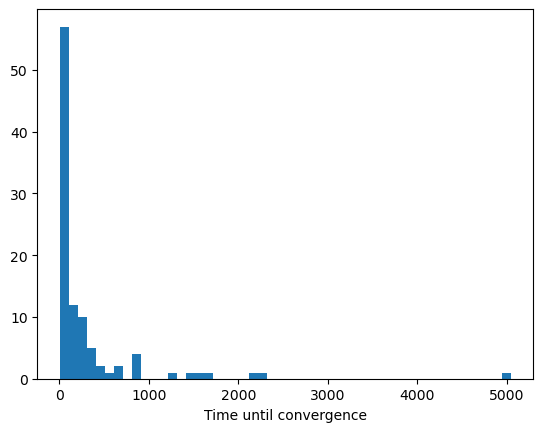

In [108]:
plot_hist_times(results, nbins = 50)

### $\alpha = 0$

Note: $\alpha$ = 0 is simply recommendations uniform at random. We can see that the recommendation process to terminate takes much longer than before.

/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


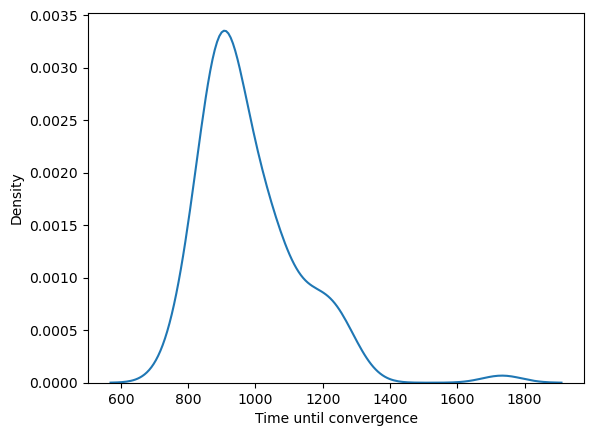

In [109]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [0], num_steps = None, random_seed = 42, evolution = 50)
results = simulation.simulate()
results_dict[0] = results
plot_density_times(results)

### $\alpha = -0.5$

We are now in the regime of negative PA. This is the regime where in the original paper we did not get any information about the convergence times, as in their experiments, only 1000 iterations were allowed. As we want to get more fine-grained information that is supposed to support decision making for which parameter to choose, we run until convergence in our experiments. We can see that in order for the algorithm to terminate, it takes even longer than random recommendations, almost always at least $4000$ iterations.

We note here that we tried the experiment for values $\alpha \leq -1$, but the convergence then takes so long that it did not finish on our computers.

/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


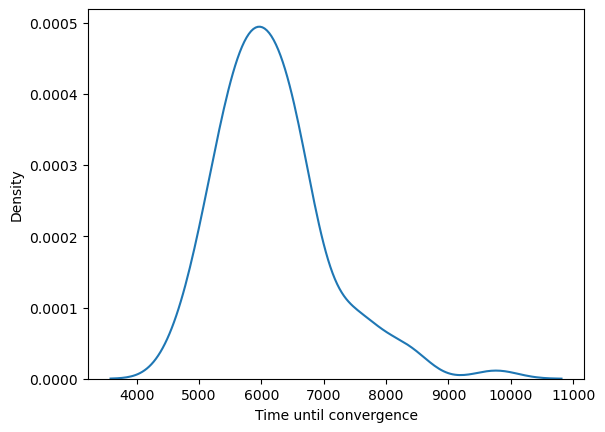

In [110]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-0.5], num_steps = None, random_seed = 42)
results = simulation.simulate()
results_dict[-0.5] = results
plot_density_times(results)

### Conclusion on convergence times

In the below plot, for clarity, we can see the different regimes next to each other. It clearly shows that the bigger $\alpha$, the better the convergence time, by a significant margin. If we put ourselves into the position of a platform owner, and we assume there will be 1-2 recommendations per day, if we choose $\alpha = -0.5$, we can expect it to take 3000 days, or more than 8 years until all users have found the best content creators, while if we choose $\alpha = 2$, it would only take 10-15 days! We can thus temporarily conclude that small values of $\alpha$ without further tricks are not suited for real world use. We will later see how we can fix this problem.

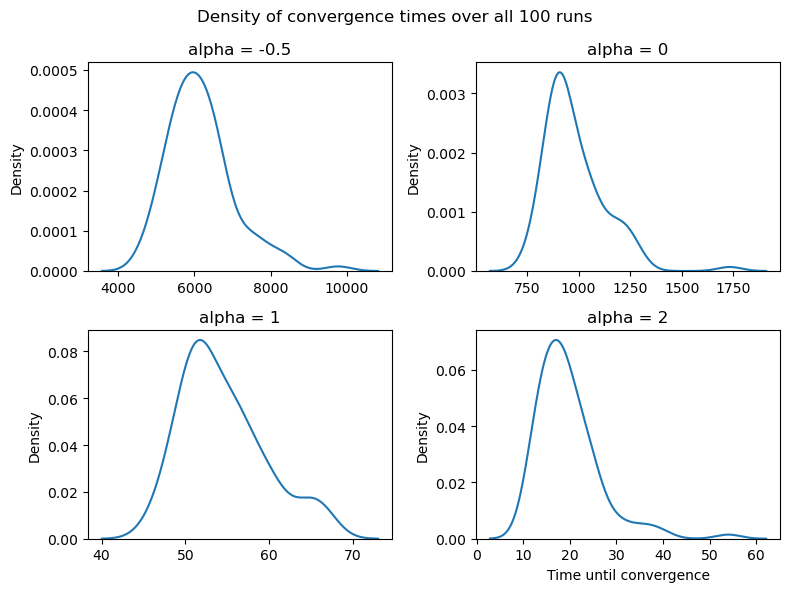

In [137]:
all_timesteps = []
for results in results_dict.values():
    timesteps = []
    for result in results.values():
        timesteps.append(result['timesteps'])
    all_timesteps.append(timesteps)

fig, axs = plt.subplots(2, 2, figsize = (8, 6))
# Plot each individual plot within its corresponding subpl
sns.kdeplot(all_timesteps[-1], ax = axs[0, 0])
axs[0, 0].set_title('alpha = -0.5')

sns.kdeplot(all_timesteps[-2], ax = axs[0, 1])
axs[0, 1].set_title('alpha = 0')

sns.kdeplot(all_timesteps[0], ax = axs[1, 0])
axs[1, 0].set_title('alpha = 1')

sns.kdeplot(all_timesteps[1], ax = axs[1, 1])
axs[1, 1].set_title('alpha = 2')

plt.xlabel('Time until convergence')
plt.ylabel('Density')
plt.suptitle('Density of convergence times over all 100 runs')
plt.tight_layout()

## Analyzing CC fairness

We have seen in the previous section that if one just wants to maximize user satisfaction and convergence time, values of $\alpha \geq 1$ are superior. However, in the paper another metric of interest was introduced - namely content creator fairness. We will see that there is an important trade-off between CC fairness and convergence times (and thus implicitly user satisfaction). Thus the choice of just using large $\alpha$ is not inherently the correct one for the owner of a platform.

We start by plotting the CC fairness of our previous simulations

In [138]:
palette = ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {1: palette[1], 2: palette[2], 3: palette[3], 0: palette[0], -0.5: 'lightblue'}
def plot_CC_fairness_all(results_dict):
    plt.figure(figsize=(8, 6))
    for alpha, results in results_dict.items():
        fairness_scores = []
        for result in results.values():
            fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
        fairness_scores = np.array(fairness_scores, dtype = float)
        plt.plot(np.array(fairness_scores).mean(axis = 0), color = colors[alpha], label = 'Alpha = ' + str(alpha))
    plt.xlabel('CC ID')
    plt.ylabel('Percentage of outcomes with ex-post CC fair outcomes')
    plt.legend()

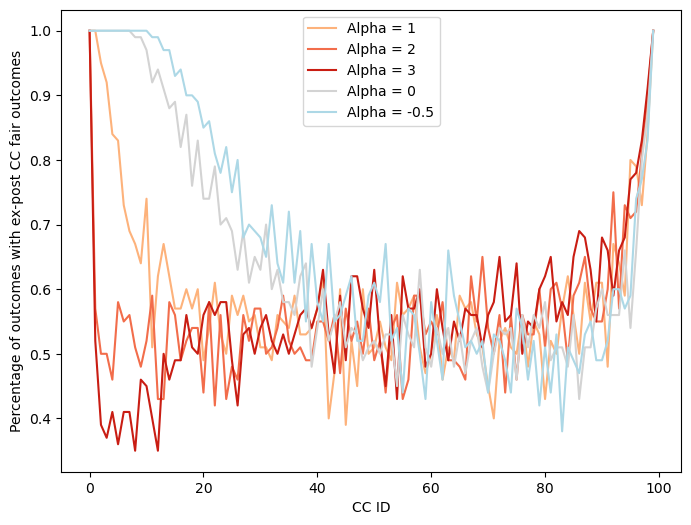

In [139]:
plot_CC_fairness_all(results_dict)

We can see that the smaller the value of $\alpha$ the fairer the recommendations are for Content Creators with rank $> 40$. This fits the results of the original paper. In order to get a better understanding about the fairness properties, we decided to also analyze the fairness averaged over all CCs and then use density plots again over all 100 runs of the simulation.

In [146]:
palette = ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {1: palette[1], 2: palette[2], 3: palette[3], 0: palette[0], -0.5: 'lightblue'}
def plot_CC_fairness_all(results_dict):
    plt.figure(figsize=(8, 6))
    for alpha, results in results_dict.items():
        fairness_scores = []
        for result in results.values():
            fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
        fairness_scores = np.array(fairness_scores, dtype = float)
        sns.kdeplot(np.array(fairness_scores).mean(axis = 1), color = colors[alpha], label = 'Alpha = ' + str(alpha))
    plt.xlabel('Percentage of outcomes with ex-post CC fair outcomes averaged over all CCs')
    plt.ylabel('Density of that percentage over all simulations')
    plt.legend()
    plt.title('Density of Percentage of Ex-Post CC fair Outcomes for different Values of Alpha')

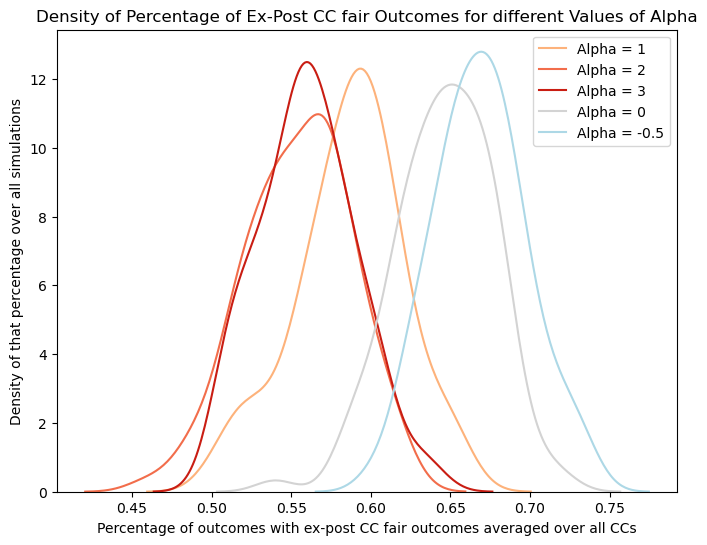

In [147]:
plot_CC_fairness_all(results_dict)

We can see that in fact, the smaller the value of $\alpha$, the fairer the recommendations, by quite a significant margin. However, we need to remember that in order to get such a fairness score, negative PA takes more than $100$ times more iterations than positive PA, as seen in previous plots. In order to properly find out what we should use in practice, we thus need to also analyze intermediary states, which is what we will be doing next.

## Analyzing Intermediary States

As we have seen, it can take a long time for negative PA to converge. We will thus now analyze states that emerge after a certain number of timesteps, without the algorithm having converged yet. We call such states intermediary states.

We first show that for $\alpha = -0.5$, even if we terminate the simulation after only $50$ steps, we are already much fairer than positive PA with any exponent, showing that the fairness depends inherently on the way recommendations are done, not on the long convergence time of negative PA. In fact, there is not a big difference in CC fairness after $50$ steps and after convergence.

In [148]:
# Run negative PA (alpha = -0.5) for a different amount of steps
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-0.5], num_steps = 50, random_seed = 42, evolution = 10)
results50 = simulation.simulate()
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-0.5], num_steps = 25, random_seed = 42, evolution = 10)
results25 = simulation.simulate()
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-0.5], num_steps = 100, random_seed = 42, evolution = 10)
results100 = simulation.simulate()

In [149]:
results_dict2 = {25: results25, 50: results50, 100: results100} 
palette = sns.color_palette('PuBu', 6)[1:][::-1]
colors = {25: palette[1], 50: palette[2], 100: palette[3], 'convergence': palette[4]}
def plot_CC_fairness_all(results_dict2):
    plt.figure(figsize=(8, 6))
    for i, results in results_dict2.items():
        fairness_scores = []
        for result in results.values():
            fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
        fairness_scores = np.array(fairness_scores, dtype = float)
        sns.kdeplot(np.array(fairness_scores).mean(axis = 1), color = colors[i], label = f'Terminate after {i} iterations')
    
    fairness_scores = []
    for result in results_dict[-0.5].values():
        fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
    fairness_scores = np.array(fairness_scores, dtype = float)
    sns.kdeplot(np.array(fairness_scores).mean(axis = 1), color = colors['convergence'], label = f'Run until convergence')
    
    
    plt.xlabel('Percentage of outcomes with ex-post CC fair outcomes averaged over all CCs')
    plt.ylabel('Density of that percentage over all simulations')
    plt.legend()
    plt.title('Density of Percentage of Ex-Post CC fair Outcomes for different states of convergence')

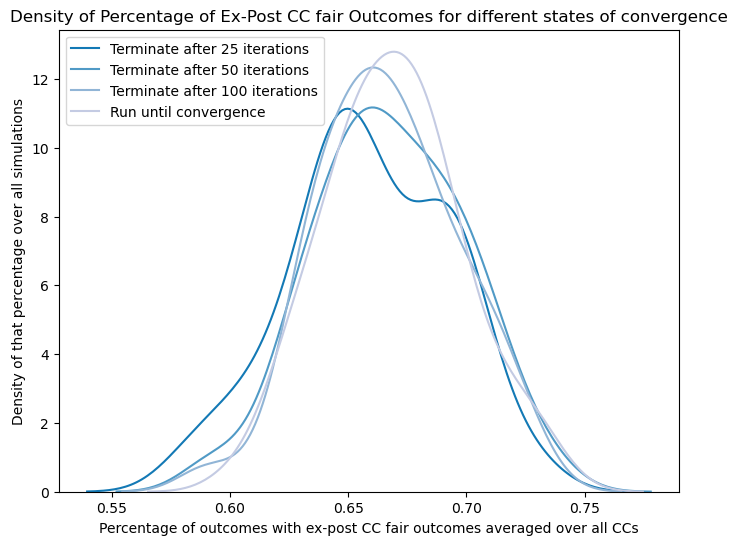

In [150]:
plot_CC_fairness_all(results_dict2)

We now run negative PA for multiple alpha values, also for $\alpha \leq -1$; as mentioned before we cannot run until convergence as with such values it takes too long. So we stop the simulation after a given number of time-steps and then analyze the state at that point; we call these intermediary states.

In [151]:
# running the experiments, collecting the data
results_interm = dict()
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [0], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
results_interm[0] = simulation.results
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-0.5], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
results_interm[-0.5] = simulation.results
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-1], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
results_interm[-1] = simulation.results
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-2], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
results_interm[-2] = simulation.results
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-3], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
results_interm[-3] = simulation.results

results_interm[1] = results_dict[1]
results_interm[2] = results_dict[2]


In [165]:
satisfaction_scores_time = {}
for alpha, results in results_interm.items():
    alpha_data = [] 
    for result in results.values():
        interm_d = []
        for e_data in result['evolutionary_data'].values():
            user_satisfactions = e_data['user_satisfactions']
            interm_d.append(np.mean(user_satisfactions))
        if len(interm_d) < 20: # in case the algorithm converges before 1000 iterations, we fill the remaining time-steps with 0 (best user satisfaction score possible)
            interm_d += [0] * (20 - len(interm_d))
        alpha_data.append(interm_d)
    satisfaction_scores_time[alpha] = np.mean(alpha_data, axis = 0)

In [179]:
fairness_scores_time = {}
for alpha, results in results_interm.items():
    alpha_data = []
    for result in results.values():
        interm_d = []
        for e_data in result['evolutionary_data'].values():
            CC_satisfactions = e_data['num_followers']
            fairness_scores = calculate_fairness(CC_satisfactions, binary_fair)
            interm_d.append(np.mean(fairness_scores))
        if len(interm_d) < 20: # in case the algorithm converges before 1000 iterations, we fill the remaining time-steps with 0 (best user satisfaction score possible)
            if len(interm_d) == 0:
                interm_d = [np.mean(calculate_fairness(result['num_followers'], binary_fair))]
            interm_d += [interm_d[-1]] * (20 - len(interm_d))
        alpha_data.append(interm_d)
    fairness_scores_time[alpha] = np.mean(alpha_data, axis = 0)

Text(0.5, 1.0, 'Evolution of user satisfaction over time')

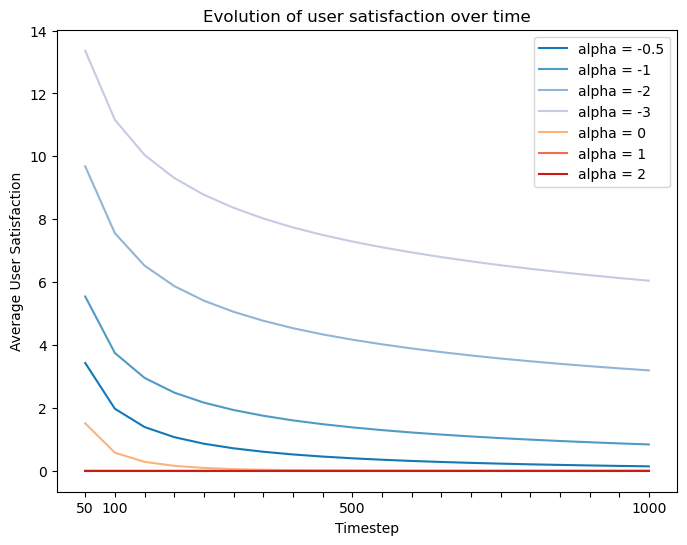

In [167]:
palette = sns.color_palette('PuBu', 6)[1:][::-1] + ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {-0.5: palette[1], -1: palette[2], -2: palette[3], -3: palette[4], 0: palette[6], 1: palette[7], 2: palette[8]}
plt.figure(figsize=(8, 6))
for alpha, satisfaction_scores in satisfaction_scores_time.items():
    plt.plot(satisfaction_scores, color = colors[alpha], label = f'alpha = {alpha}')
plt.xlabel('Timestep')
plt.ylabel('Average User Satisfaction')
plt.xticks(range(0, 20), [50, 100] + ['']*7 + [500] + ['']*9 + [1000])
plt.legend()
plt.title('Evolution of user satisfaction over time')

Text(0.5, 1.0, 'Evolution of CC fairness over time')

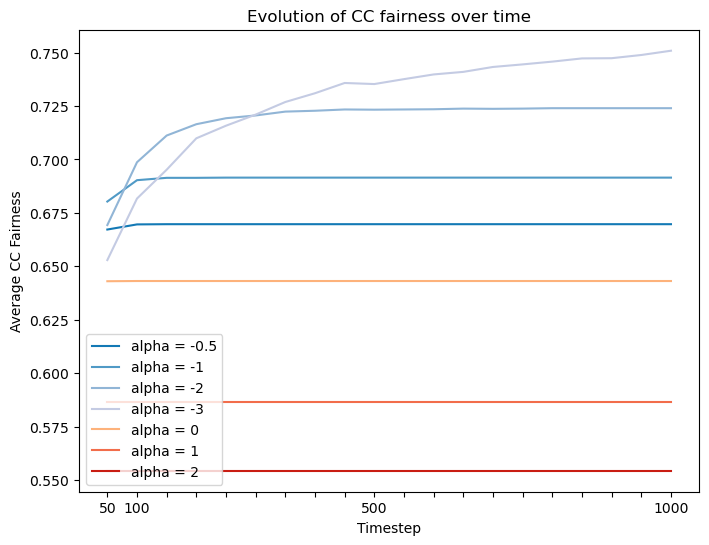

In [182]:
palette = sns.color_palette('PuBu', 6)[1:][::-1] + ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {-0.5: palette[1], -1: palette[2], -2: palette[3], -3: palette[4], 0: palette[6], 1: palette[7], 2: palette[8]}
plt.figure(figsize=(8, 6))
for alpha, fairness_scores in fairness_scores_time.items():
    plt.plot(fairness_scores, color = colors[alpha], label = f'alpha = {alpha}')
plt.xlabel('Timestep')
plt.ylabel('Average CC Fairness')
plt.xticks(range(0, 20), [50, 100] + ['']*7 + [500] + ['']*9 + [1000])
plt.legend()
plt.title('Evolution of CC fairness over time')

We can see that the trend from positive PA and negative PA continues when just considering negative PA values: the smaller the value of $\alpha$, the slower the convergence, but the better the CC fairness.

## So how do we choose $\alpha$? A new approach.

In the previous sections we have seen that there is a trade-off in the choice of $\alpha$: If the owner of a social media website wants to have fast convergence, that is, if the owner wants to maximize user satisfaction, then one should choose $\alpha \in [1, 2]$. However, as we have also seen, this leads to low fairness for content creators. So if the owner wants to guarantee fairness, they would have to choose $\alpha < 0$. However, in this case, convergence takes multiple orders of magnitude longer than under positive PA. With the current options for $\alpha$, this is all we can say as a heuristic for an owner of a network. They will have to choose depending on what they want to optimize. They cannot achieve a very good trade-off though. For any value of $\alpha < 0$, convergence takes long; but as soon as $\alpha \geq 0$, the CC fairness scores drop dramatically.

We make an improvement to this by providing an algorithm that achieves a better trade-off in both of those metrics. We call it $(\alpha_1, \alpha_2, \ldots, \alpha_k)$-PA. It works as follows:

1: At timestep $t$, sample an index $i$ from $\{1, 2, \ldots, k\}$ uniformly at random

2: Perform $\alpha_i$-PA at this timestep.

We will now give one example how it is better than standard PA. In order to get an average convergence time of $\leq 200$, we need to choose $\alpha \geq 0.5$. We empirically show that for an $(-3, 1)$-PA, we can achieve significantly shorter average convergence time will still improving on the average CC-fairness. This is just one demonstration, we have checked it empirically for other values as well. Always a well-calibrated $(\alpha_1, \alpha_2, \ldots, \alpha_k)$-PA outperformed a standard PA. As an extra bonus we also see decreased variance in our approach in comparison to standard PA.

In [71]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-3, 1], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
multiple_alphas_results = simulation.results

simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [0.5], num_steps = 1000, random_seed = 42, evolution = 50)
simulation.simulate()
standard_PA_results = simulation.results

/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Comparison of CC fairness scores for our algorithm and standard PA')

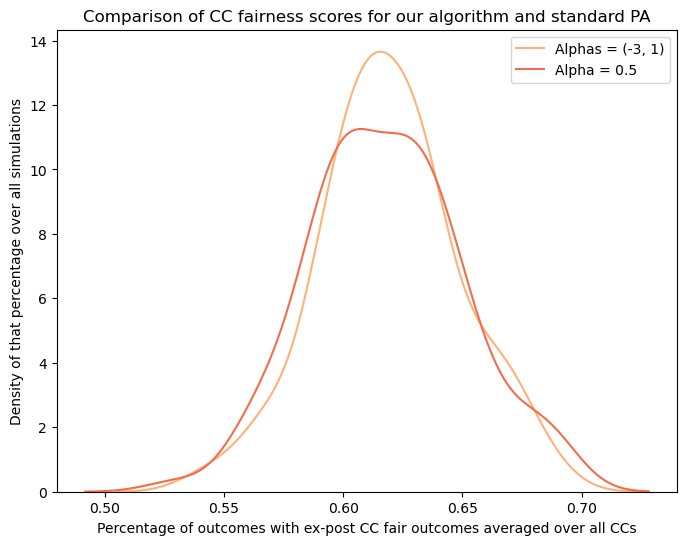

In [75]:
palette = ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {1: palette[1], 2: palette[2], 3: palette[3], 0: palette[0], -0.5: 'lightblue'}
plt.figure(figsize=(8, 6))

fairness_scores = []
for result in multiple_alphas_results.values():
    fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
fairness_scores = np.array(fairness_scores, dtype = float)
sns.kdeplot(np.array(fairness_scores).mean(axis = 1), color = colors[1], label = 'Alphas = (-3, 1)')

fairness_scores = []
for result in standard_PA_results.values():
    fairness_scores.append(calculate_fairness(result['num_followers'], binary_fair))
fairness_scores = np.array(fairness_scores, dtype = float)
sns.kdeplot(np.array(fairness_scores).mean(axis = 1), color = colors[2], label = 'Alpha = 0.5')

plt.xlabel('Percentage of outcomes with ex-post CC fair outcomes averaged over all CCs')
plt.ylabel('Density of that percentage over all simulations')
plt.legend()
plt.title('Comparison of CC fairness scores for our algorithm and standard PA')

/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/network/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Comparison of convergence times for our algorithm and standard PA')

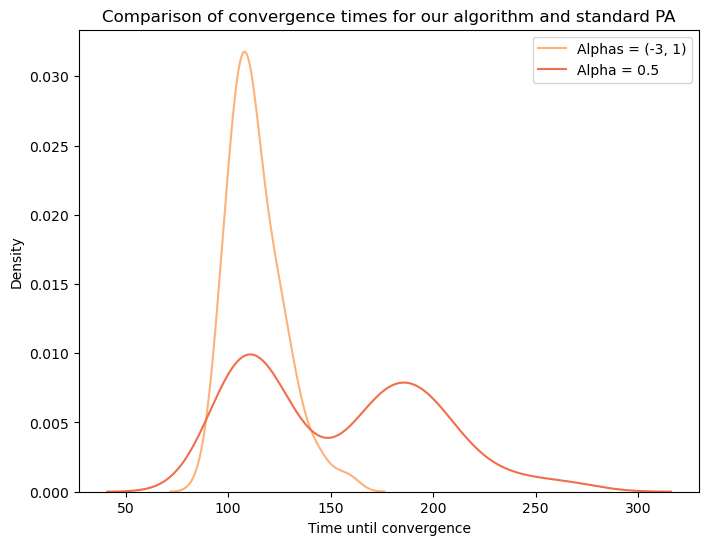

In [76]:
palette = ['#D3D3D3']+ sns.color_palette('OrRd', 4)[1:]
colors = {1: palette[1], 2: palette[2], 3: palette[3], 0: palette[0], -0.5: 'lightblue'}
plt.figure(figsize=(8, 6))

timesteps = []
for result in multiple_alphas_results.values():
    timesteps.append(result['timesteps'])
sns.kdeplot(np.array(timesteps), color = colors[1], label = 'Alphas = (-3, 1)')

fairness_scores = []
for result in standard_PA_results.values():
    timesteps.append(result['timesteps'])
sns.kdeplot(np.array(timesteps), color = colors[2], label = 'Alpha = 0.5')

plt.xlabel('Time until convergence')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of convergence times for our algorithm and standard PA')

## Conclusion

We have shown that if one wants to choose which recommendation algorithm to use, there is an inherent trade-off between user-satisfaction and CC-fairness. We have devised a new modification of standard PA that tries to mitigate this trade-off and indeed manages to do so by a significant margin. We believe that $(-3, 1)$-PA is a very reasonable choice of parameters for an owner of a recommendation platform, achieving a good trade-off. However, the exact values have to be specified based on the exact requirements how a platform should behave.

## Appendix (1): Further experimental data for $(\alpha_1, \alpha_2, \ldots, \alpha_k)$-PA

### $(-3, -3, -3, -3, -3, -3, 1)$-PA is as fair as $-0.5$-negPA, but takes 15 times shorter to converge

In [211]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-3, -3, -3, -3, -3, -3, 1], num_steps = None, random_seed = 42, evolution = 50)
simulation.simulate()
multiple_alphas_results = simulation.results

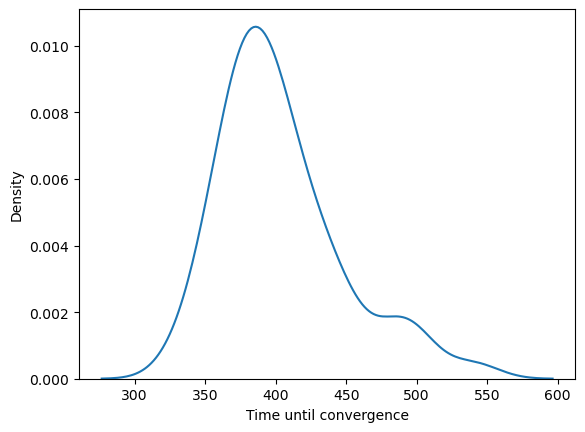

In [212]:
plot_density_times(multiple_alphas_results)

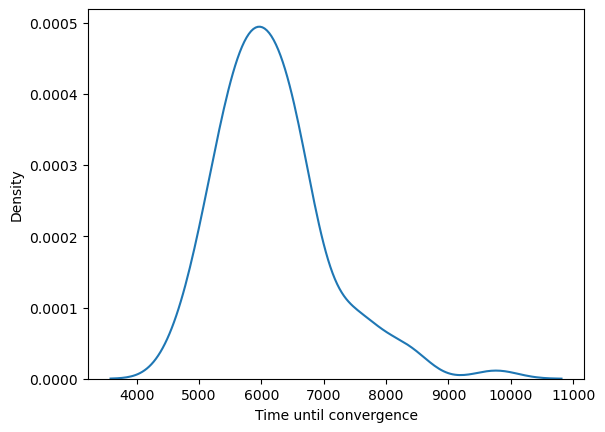

In [218]:
plot_density_times(results_dict[-0.5])

In [215]:
average_fairness(multiple_alphas_results, binary_fair)

0.6678

In [216]:
average_fairness(results_dict[-0.5], binary_fair)

0.6689

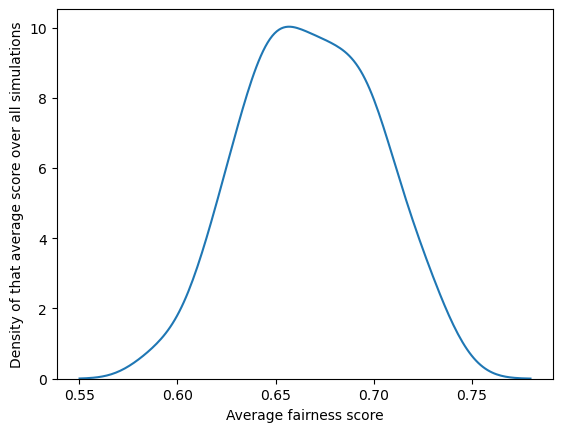

In [214]:
plot_average_fairness(multiple_alphas_results, binary_fair)

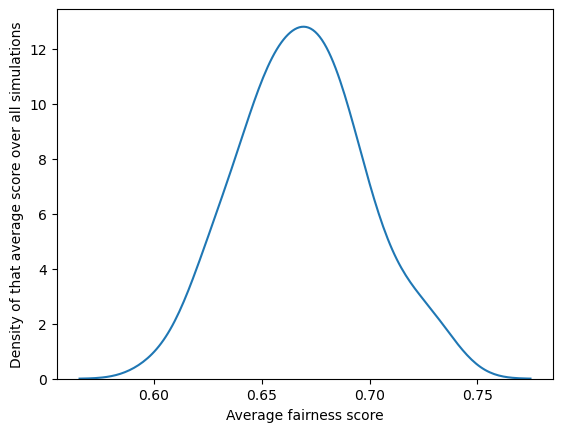

In [217]:
plot_average_fairness(results_dict[-0.5], binary_fair)

## Appendix (2): Other potentially interesting results / experiments

### Increasing the number of CCs and users

In the original paper, the numbe of CCs and users were fixed at 100 and 10000, respectively. No experiments were done with other parameters, and we thought it would be interesting to see how performance changes when these parameters are varied.

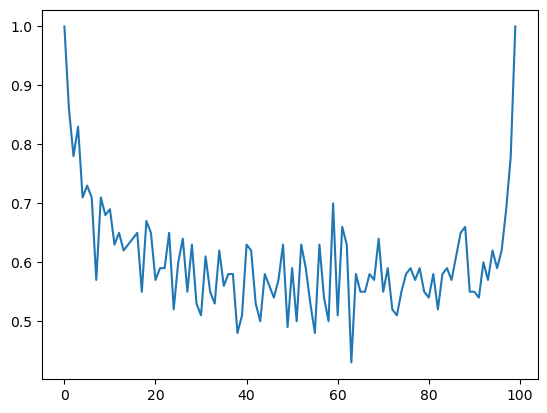

In [78]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  100000, alphas = [2], num_steps = None, random_seed = 42)
results = simulation.simulate()
plot_fairness(results, binary_fair)

We can see that if we just increase the number of users by a factor of 10, the CC satisfaction upon termination increases.

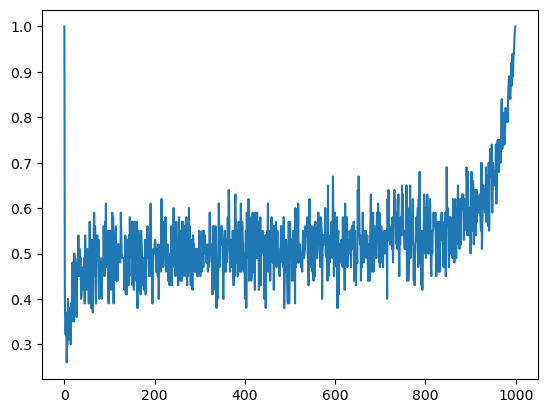

In [80]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 1000, num_users =  100000, alphas = [2], num_steps = None, random_seed = 42)
results = simulation.simulate()
plot_fairness(results, binary_fair)

We can see that if we increase both the number of users as well as the number of CCs by the same factor fo 10, the CC satisfaction significantly decreases. To us, this shows us that further theoretical analysis of the regime where both numbers go to infinity simultaneously is needed.

### Evolution of probabilities

In order to better interpret the different regimes, in particular negative PA, we also wanted to look at how the probabilities that a CC gets recommended change over time.

In [90]:
simulation = sim.Simulation(num_simulations = 100, num_CCs = 100, num_users =  10000, alphas = [-3, 1], num_steps = None, random_seed = 42, evolution = 10)
results = simulation.simulate()

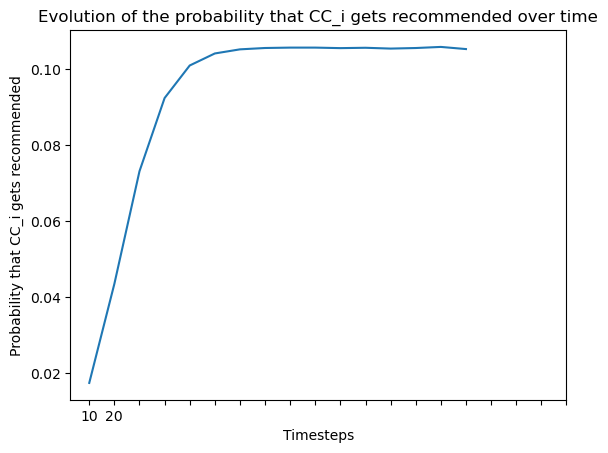

In [96]:
# probabilities for CC_0
plot_probabilities2(results, 0)

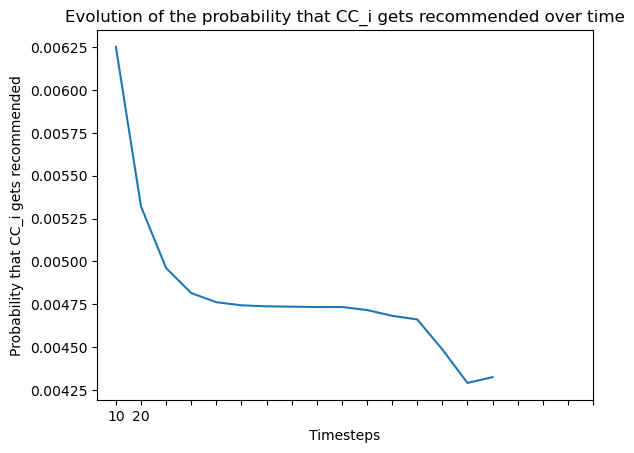

In [97]:
# probabilities for CC_50
plot_probabilities2(results, 50)

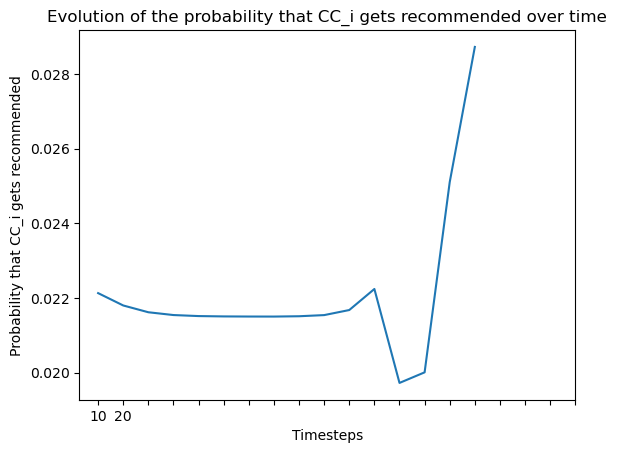

In [98]:
# probabilities for CC_99
plot_probabilities2(results, 99)